This script was run locally on my laptop. The following files were copied to my laptop to run it:
- `/cbica/projects/clinical_dmri_benchmark/results/discriminability/two_sample_GQIautotrack_CSDautotrack.csv`
- `/cbica/projects/clinical_dmri_benchmark/results/discriminability/two_sample_CSDautotrack_SS3Tautotrack.csv`
- `/cbica/projects/clinical_dmri_benchmark/results/discriminability/two_sample_GQIautotrack_SS3Tautotrack.csv`

These are the outputs of the following script:
`clinical_dmri_benchmark/analysis/discriminability/discrim_two_sample_filtered.sh`

In [6]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import font_manager
import os

In [ ]:
# Read csv's and combine them to one global csv
DISCRIM_CSV_ROOT = "/Users/amelie/Datasets/clinical_dmri_benchmark/discriminability"

discrim_df_GQI_CSD = pd.read_csv(os.path.join(
    DISCRIM_CSV_ROOT, "two_sample_GQIautotrack_CSDautotrack.csv"))
discrim_df_GQI_CSD = discrim_df_GQI_CSD.rename(
    columns={"p-value": "p-value_GQI-CSD"})
discrim_df_CSD_SS3T = pd.read_csv(os.path.join(
    DISCRIM_CSV_ROOT, "two_sample_CSDautotrack_SS3Tautotrack.csv"))
discrim_df_CSD_SS3T = discrim_df_CSD_SS3T.rename(
    columns={"p-value": "p-value_CSD-SS3T"})
discrim_df_GQI_SS3T = pd.read_csv(os.path.join(
    DISCRIM_CSV_ROOT, "two_sample_GQIautotrack_SS3Tautotrack.csv"))
discrim_df_GQI_SS3T = discrim_df_GQI_SS3T.rename(
    columns={"p-value": "p-value_GQI-SS3T"})

discrim_df = pd.merge(discrim_df_GQI_CSD, discrim_df_CSD_SS3T, how="outer", on=[
                      "bundle", "discrim_CSDautotrack"])
discrim_df = pd.merge(discrim_df, discrim_df_GQI_SS3T, how="outer", on=[
                      "bundle", "discrim_SS3Tautotrack", "discrim_GQIautotrack"])
# save the csv with all results
discrim_df.to_csv(os.path.join(DISCRIM_CSV_ROOT, "discrim_two_sample.csv"))

# keep only columns necessary for plot and rename for convenience
discrim_df = discrim_df.drop(
    columns=["p-value_GQI-CSD", "p-value_GQI-SS3T", "p-value_CSD-SS3T"])
discrim_df = discrim_df.melt(
    id_vars=["bundle"], var_name="Method", value_name="Discriminability")
discrim_df = discrim_df.replace("discrim_GQIautotrack", "GQI")
discrim_df = discrim_df.replace("discrim_CSDautotrack", "CSD")
discrim_df = discrim_df.replace("discrim_SS3Tautotrack", "SS3T")

In [7]:
# Test for significance between discriminability distributions
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

comparisons = [
    ("GQI", "CSD"),
    ("GQI", "SS3T"),
    ("CSD", "SS3T")
]

p_vals = []
for a, b in comparisons:
    data_a = discrim_df[discrim_df["Method"] == a]["Discriminability"].values
    data_b = discrim_df[discrim_df["Method"] == b]["Discriminability"].values
    p_vals.append(wilcoxon(data_a, data_b).pvalue)
_, pvals_corrected, _, _ = multipletests(p_vals, method='fdr_bh')

print("Pairwise Wilcoxon test results (FDR-corrected):")
for i, (a, b) in enumerate(comparisons):
    print(f"{a} vs {b}: raw p = {p_vals[i]:.5f}, corrected p = {pvals_corrected[i]:.5f}")

Pairwise Wilcoxon test results (FDR-corrected):
GQI vs CSD: raw p = 0.00204, corrected p = 0.00306
GQI vs SS3T: raw p = 0.00323, corrected p = 0.00323
CSD vs SS3T: raw p = 0.00000, corrected p = 0.00000


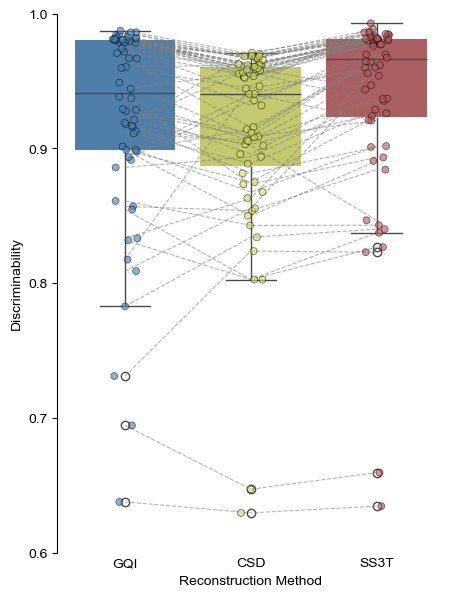

In [ ]:
# plot
# set font, palette and figure size
if "Arial" in set(f.name for f in font_manager.fontManager.ttflist):
    mpl.rcParams["font.family"] = "Arial"
my_palette = sns.color_palette(
    [(64/255, 127/255, 183/255), (208/255, 217/255, 92/255), (182/255, 82/255, 86/255)])
sns.set_palette(my_palette)
plt.figure(figsize=(5, 7))

bp = sns.boxplot(data=discrim_df, x="Method", y="Discriminability", hue="Method",
                 legend=False, hue_order=["GQI", "CSD", "SS3T"], boxprops={"edgecolor": "none"})
bp.set_ylim(0.6, 1)
bp.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
sns.stripplot(data=discrim_df, x="Method", y="Discriminability", hue="Method", legend=False,
              alpha=0.6, marker="o", edgecolor="black", linewidth=0.5, hue_order=["GQI", "CSD", "SS3T"])
for bundle, group in discrim_df.groupby("bundle"):
    plt.plot(group["Method"], group["Discriminability"],
             linestyle="--", linewidth=0.8, alpha=0.6, color="gray")

for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.gca().spines["left"].set_visible(True)
plt.tick_params(axis="x", which="both", length=0)
plt.xlabel("Reconstruction Method")
plt.savefig("../../figures/discriminability.svg")